In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
dofs = 8
num_states = 5
num_time_histories = 100 # Number of time-histories

In [3]:
# Processing columns data to fit ARX Model


def get_feature_df(state):
    features = state.copy()
    features.columns = [f"y{i+1}(k)" for i in range(dofs)]
    for i in range(dofs):
        features[f"y{i+1}(k-1)"] = features[f"y{i+1}(k)"].shift()
        features[f"y{i+1}(k-2)"] = features[f"y{i+1}(k)"].shift(2)
    features.drop(columns=[f"y{i+1}(k)" for i in range(1, dofs)], inplace=True)
    features.dropna(inplace=True)
    return features

In [4]:
from sklearn.linear_model import LinearRegression

sigma = np.zeros((num_time_histories, num_states, dofs)) # STD of residual errors | all masses | size = dofs
for time_history in range(num_time_histories):
    state0 = pd.read_csv(f"datasets/state0_datasets/state0_acceleration_timehistory{time_history+1}.csv", index_col="Time")
    features0 = get_feature_df(state0)
    model_parameters = [] # list of fitted models | all masses | size = dofs
    for i in range(dofs):
        model = LinearRegression().fit(features0.values,(state0[[f'm{i+1}']].values)[2:])
        model_parameters.append(model)

    for state in range(num_states):
        state_df = pd.read_csv(f"datasets/state{state}_datasets/state{state}_acceleration_timehistory{time_history+1}.csv", index_col="Time")
        features_df = get_feature_df(state_df)
        for i in range(dofs):
            predicted = model_parameters[i].predict(features_df.values)
            measured = (state_df[[f'm{i+1}']].values)[2:]
            residual = measured - predicted
            sigma[time_history][state][i] = np.std(residual)

sigma_ratio = np.copy(sigma)
for time_history in range(num_time_histories):
    sigma_ratio[time_history] = sigma_ratio[time_history]/sigma_ratio[time_history][0]


In [5]:
sigma[1]

array([[6.79208552e-15, 4.50867176e-12, 4.33151070e-12, 4.32734159e-12,
        4.52014184e-12, 4.51337054e-12, 4.33750221e-12, 2.54998838e-12],
       [6.79184336e-15, 8.11485978e-06, 3.76176220e-04, 3.76921226e-04,
        3.08788294e-04, 3.08624370e-04, 4.74973117e-06, 3.56668479e-06],
       [6.79280162e-15, 1.68237664e-05, 7.74130567e-04, 7.75538775e-04,
        6.32647835e-04, 6.32241755e-04, 9.82714278e-06, 7.40571814e-06],
       [6.79469831e-15, 3.63220570e-05, 1.64207181e-03, 1.64440327e-03,
        1.31739122e-03, 1.31609543e-03, 2.10840752e-05, 1.60360358e-05],
       [6.79500030e-15, 1.19859417e-04, 4.76595756e-03, 4.76534311e-03,
        3.13528788e-03, 3.12520887e-03, 6.67757210e-05, 5.34336812e-05]])

In [6]:
sigma_df = pd.DataFrame(columns = ["health", "state"] + [f"sigma_m{i+1}" for i in range(dofs)])

for time_history in range(num_time_histories):
   temp = pd.DataFrame(sigma[time_history], columns = [f"sigma_m{i+1}" for i in range(dofs)])
   sigma_df = sigma_df.append(temp, ignore_index=True)
   
sigma_df["health"] = ([0] + [1] * (num_states - 1)) * num_time_histories
sigma_df["state"] = [i for i in range(num_states)] * num_time_histories
sigma_df.to_csv("datasets/ARX_feature_sigma.csv", index=False)

In [7]:
sigma_ratio_df = pd.DataFrame(columns = ["health", "state"] + [f"std_ratio_m{i+1}" for i in range(dofs)])

for time_history in range(num_time_histories):
   temp = pd.DataFrame(sigma_ratio[time_history], columns = [f"std_ratio_m{i+1}" for i in range(dofs)])
   sigma_ratio_df = sigma_ratio_df.append(temp, ignore_index=True)
   
sigma_ratio_df["health"] = ([0] + [1] * (num_states - 1)) * num_time_histories
sigma_ratio_df["state"] = [i for i in range(num_states)] * num_time_histories

sigma_ratio_df.to_csv("datasets/ARX_feature_sigma_ratio.csv", index=False)

In [8]:
X = sigma_df.iloc[:,2:]
y = sigma_df['health']

Xr = sigma_ratio_df.iloc[:,2:]
yr = sigma_ratio_df['health']
y

0      0
1      1
2      1
3      1
4      1
      ..
495    0
496    1
497    1
498    1
499    1
Name: health, Length: 500, dtype: int64

In [9]:
# AR Feature Selection

# Chi-squared

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

ordered_rank_features = SelectKBest(score_func=chi2, k=8)
ordered_features = ordered_rank_features.fit(X, y)
score1 = pd.DataFrame(ordered_features.scores_, columns=["Score"])
score1 = pd.concat([pd.DataFrame(X.columns), score1], axis = 1)
score1

,0,Score
0,sigma_m1,5.079583e-19
1,sigma_m2,4.533423e-03
2,sigma_m3,1.885778e-01
3,sigma_m4,1.886736e-01
4,sigma_m5,1.335551e-01
5,sigma_m6,1.332800e-01
6,sigma_m7,2.561916e-03
7,sigma_m8,2.013518e-03


<AxesSubplot:>

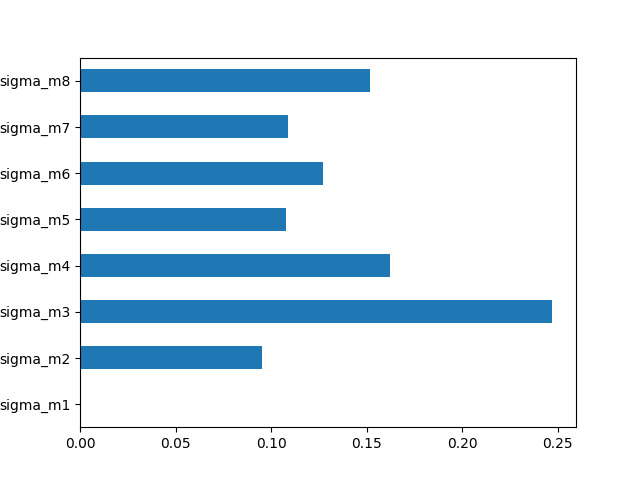

In [10]:
# Feature Importance

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X, y)
ranked_features = pd.Series(model.feature_importances_, index=X.columns)
ranked_features.plot(kind='barh')

In [11]:
# Pearson's Correlation

import seaborn as sns

corr_df = pd.concat([sigma_ratio_df["health"], sigma_ratio_df.iloc[:, 2:]], axis = 1)
corr_df = corr_df.corr()
#plt.figure(figsize=(10,10))
#sns.heatmap(corr_df[corr_df.index].corr(), annot=True)

In [12]:
# Information Gain

from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(Xr, yr)
mutual_info_df = pd.Series(mutual_info, index=Xr.columns)
mutual_info_df

sigma_ratio_m1    0.486576
sigma_ratio_m2    0.501404
sigma_ratio_m3    0.501404
sigma_ratio_m4    0.501404
sigma_ratio_m5    0.501404
sigma_ratio_m6    0.501404
sigma_ratio_m7    0.501404
sigma_ratio_m8    0.501404
dtype: float64